In [1]:
!python -m pip install multiple-hypothesis-testing

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    # import glob; print(glob.glob('/content/gdrive/Othercomputers/My Laptop/projects/RUNI/Thesis/*'))
    import sys
    sys.path.append('/content/gdrive/Othercomputers/My Laptop/projects/RUNI/Thesis')
except:
    pass

In [3]:
from Synthetic_Data_Generators import Multi_Class_Normal_Population as Data_Generator
from Synthetic_Data_Generators import Two_Lists_Tuple, Data_Generator_Noise
from Higher_Criticism import Higher_Criticism
higher_criticism = Higher_Criticism(gamma=0.2)

In [4]:
import scipy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = 'monospace'


In [5]:

N = 10000
monte_carlo=10000
alpha = 0.05

parameters_tuple = [(0.,0.)]
beta_range = np.arange(0.5,1.0,5)
r_range = np.linspace(0.1,0.5,5)
params_list = Data_Generator.params_list_from_N_r_beta(N=N, r=list(r_range), beta=list(beta_range))
signal_generators = [Data_Generator(**params) for params in params_list]
data_generators = [Data_Generator_Noise(N)]
data_generators += signal_generators
collected_data = []

for data_generator in data_generators:
    mu = data_generator.mus[-1]
    fraction = data_generator.sizes[-1] / np.sum(data_generator.sizes)
    print(f'Collecting measurments for signal mu={mu:.2f} signal size={fraction*100:.2f}%')
    res_monte_carlo = higher_criticism.monte_carlo_statistics(monte_carlo=monte_carlo, data_generator=data_generator)
    collected_data.append((mu, fraction,res_monte_carlo))
    

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Analyzing mu=0.00 fraction=100.00%


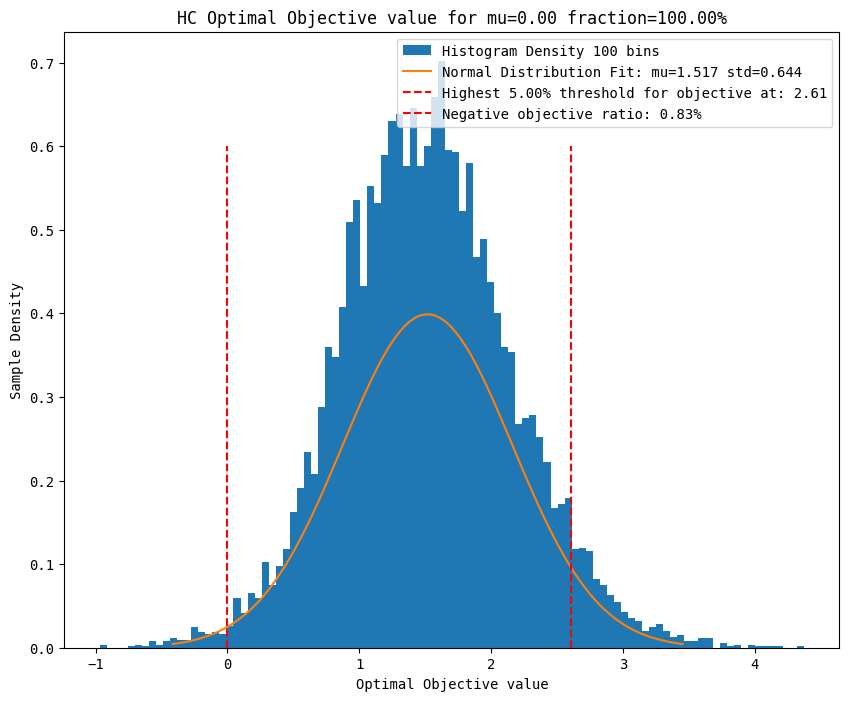

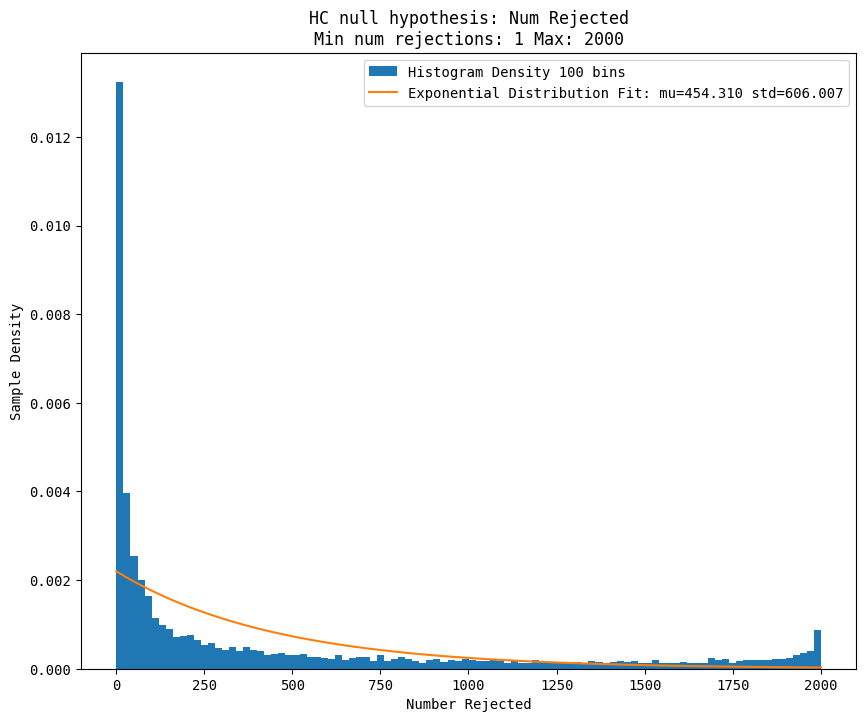

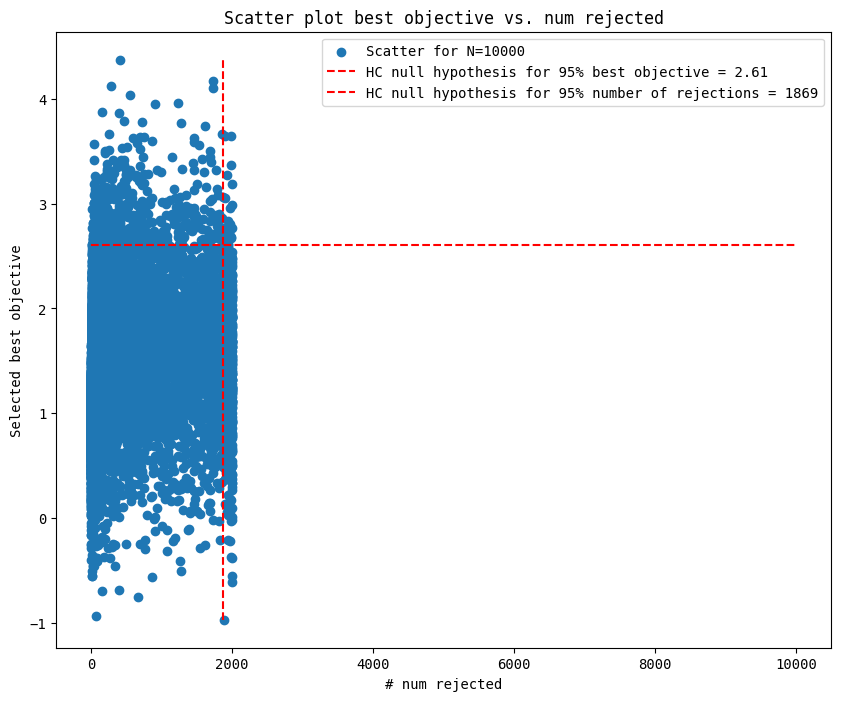


Analyzing mu=1.36 fraction=1.00%


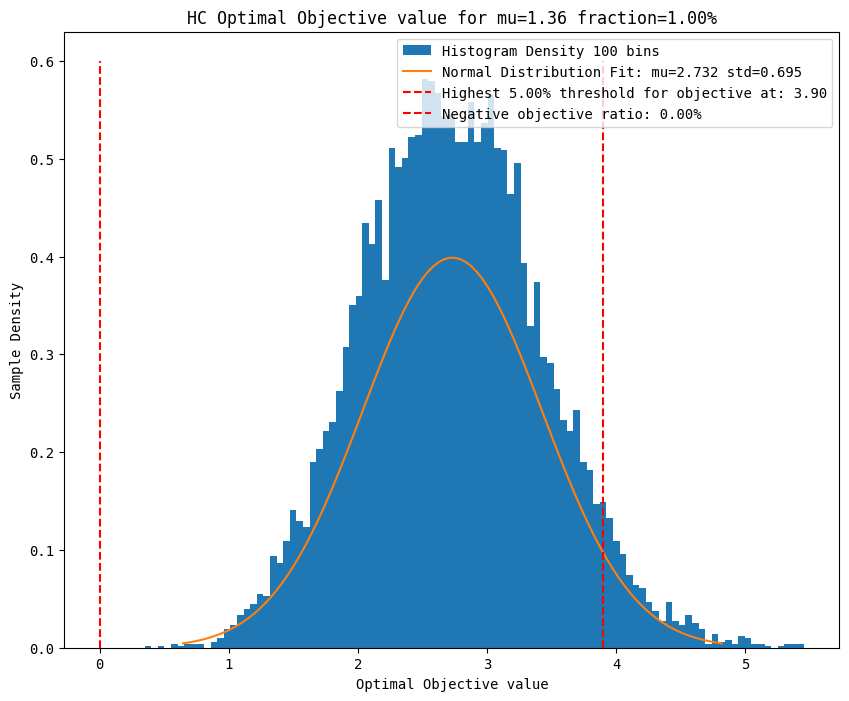

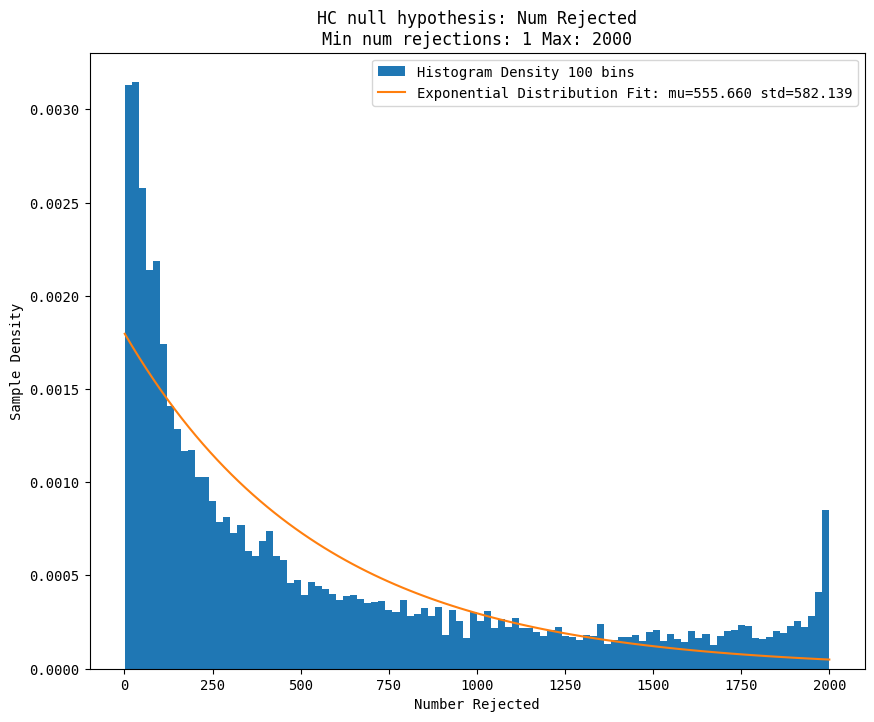

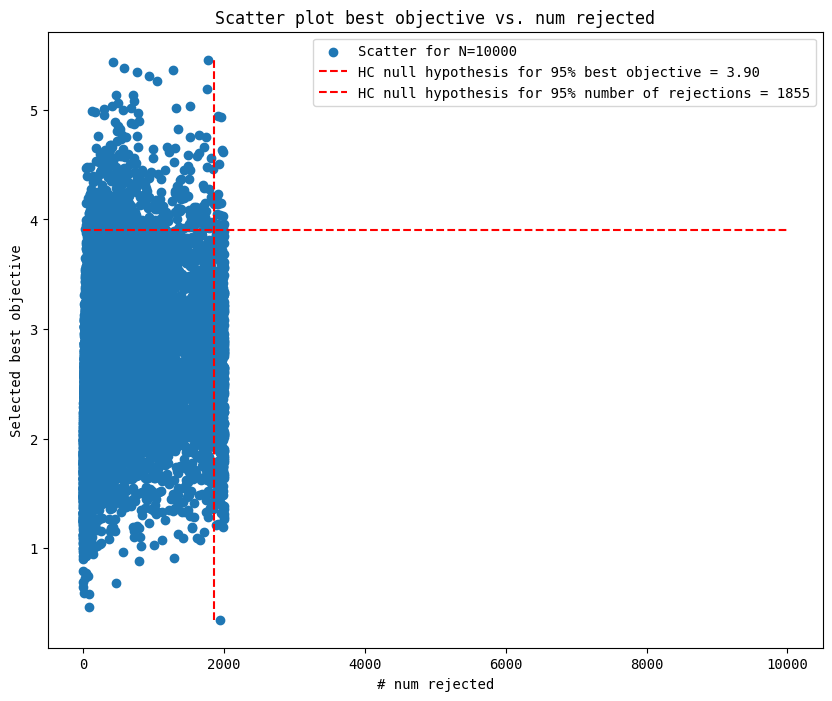


Analyzing mu=1.92 fraction=1.00%


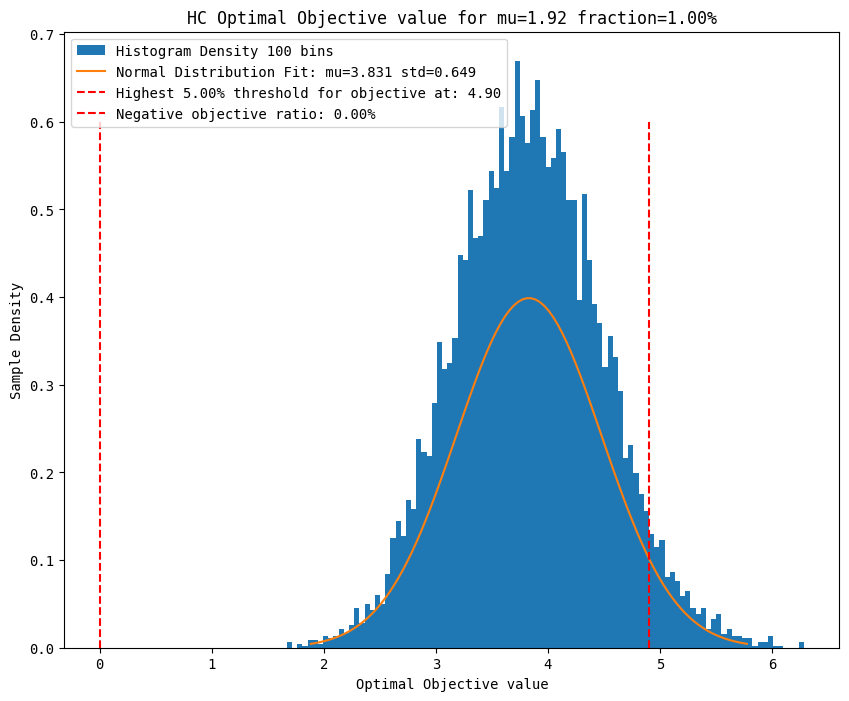

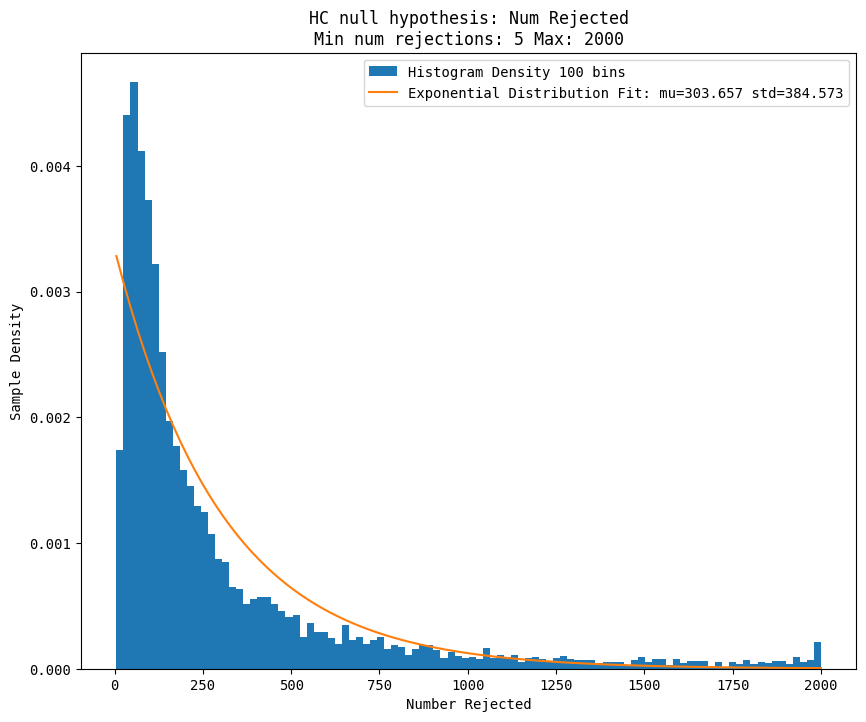

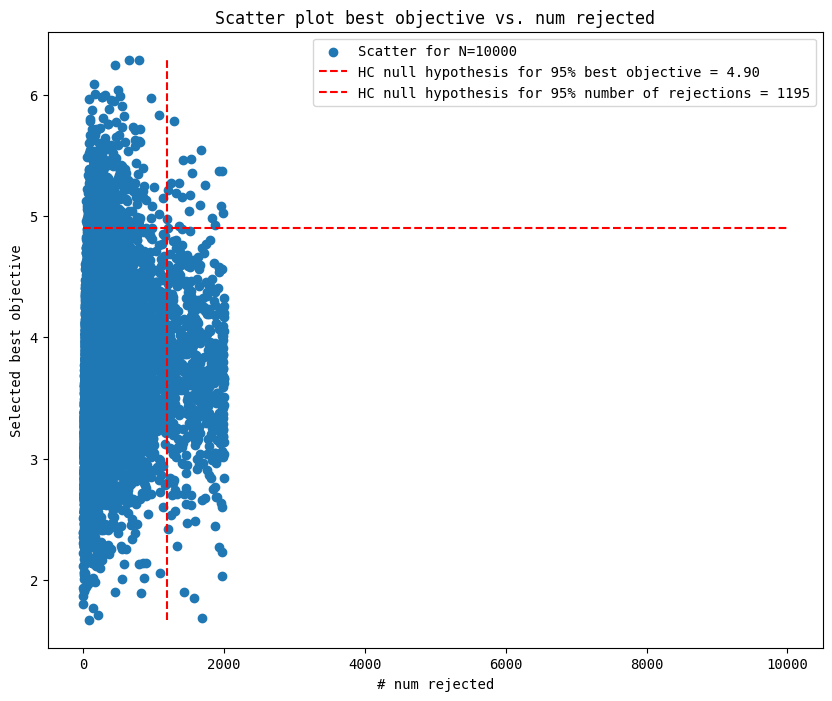


Analyzing mu=2.35 fraction=1.00%


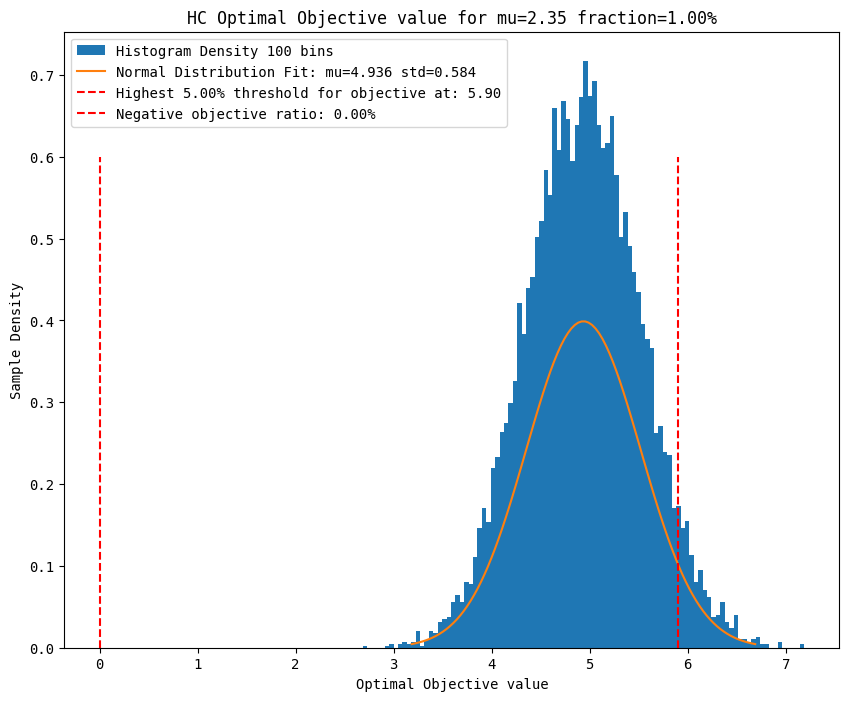

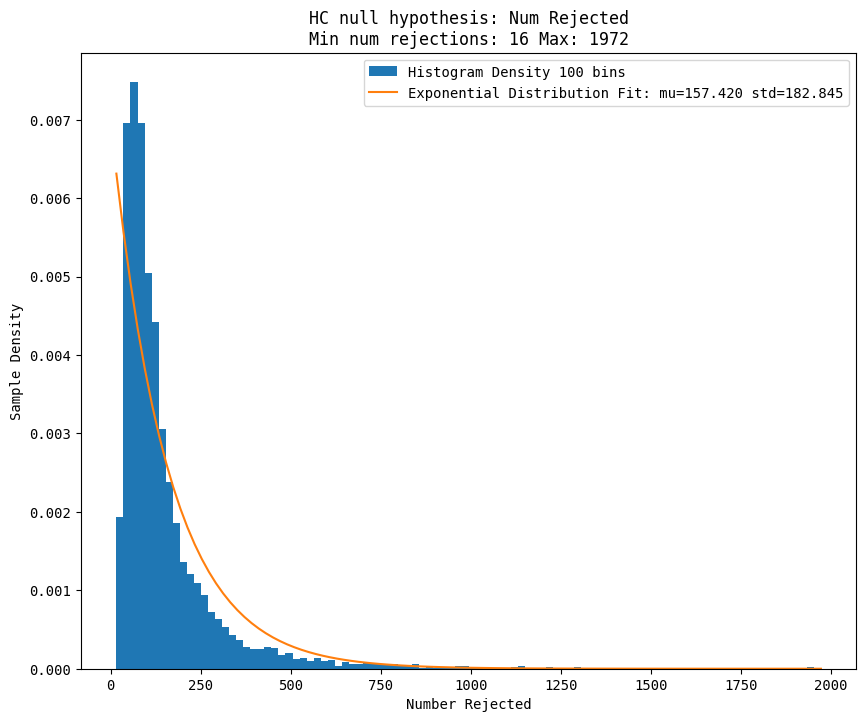

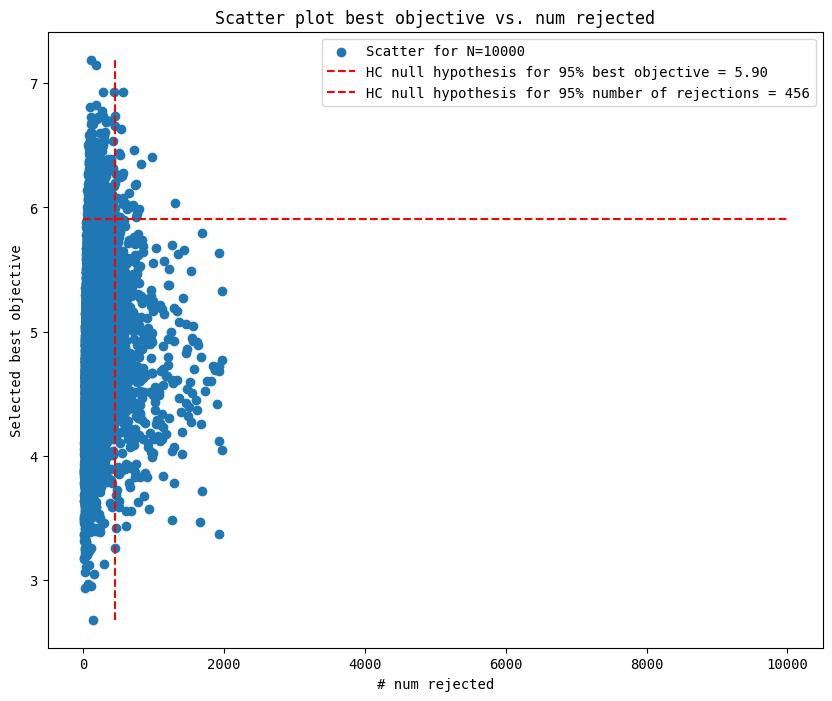


Analyzing mu=2.71 fraction=1.00%


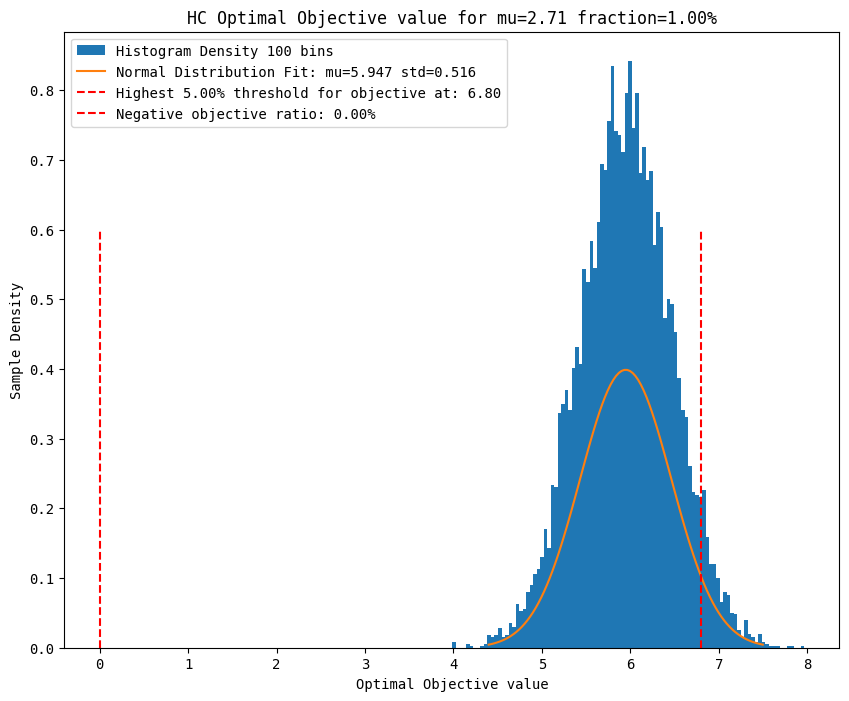

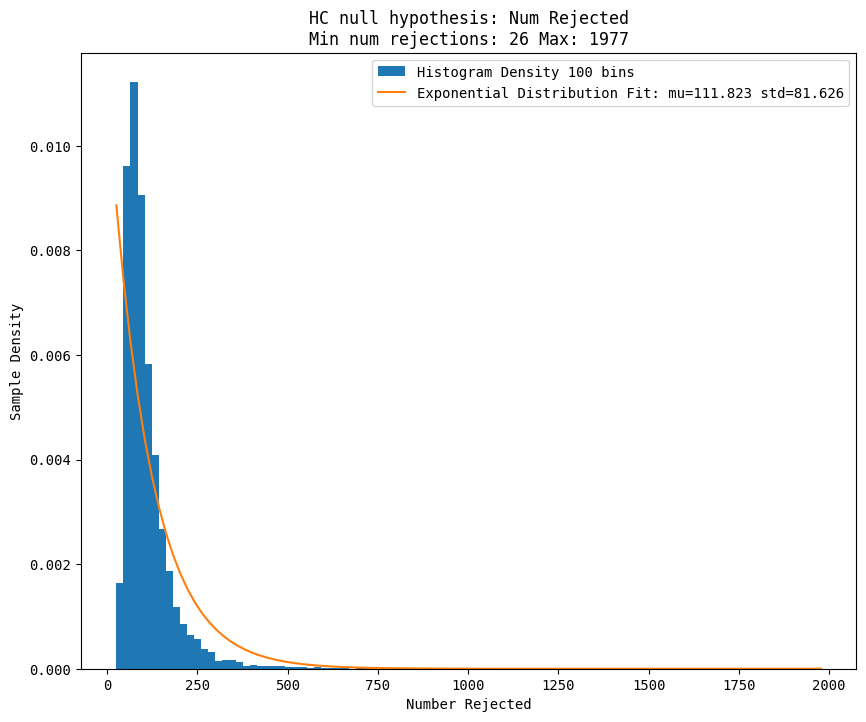

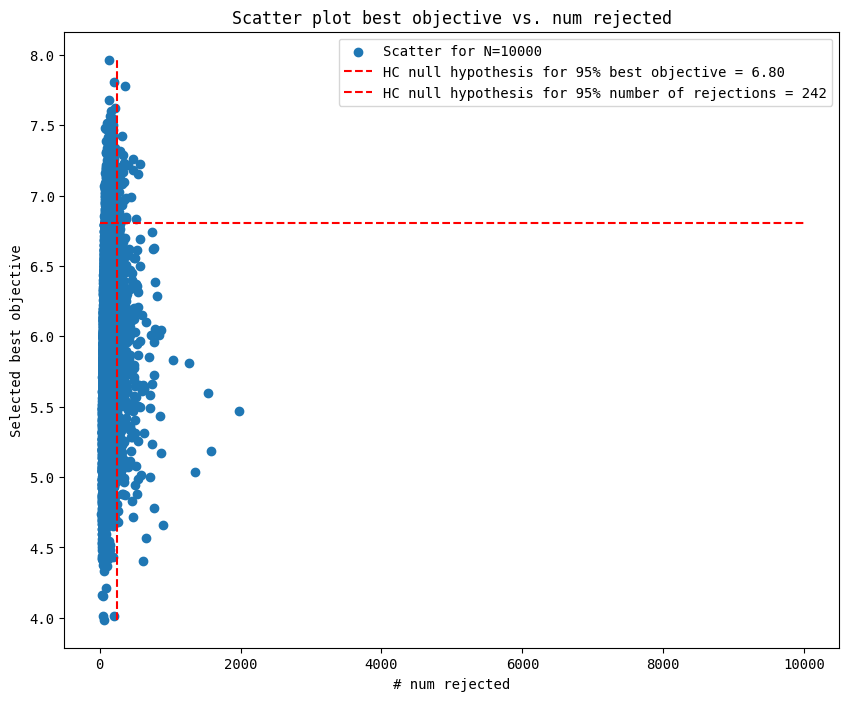


Analyzing mu=3.03 fraction=1.00%


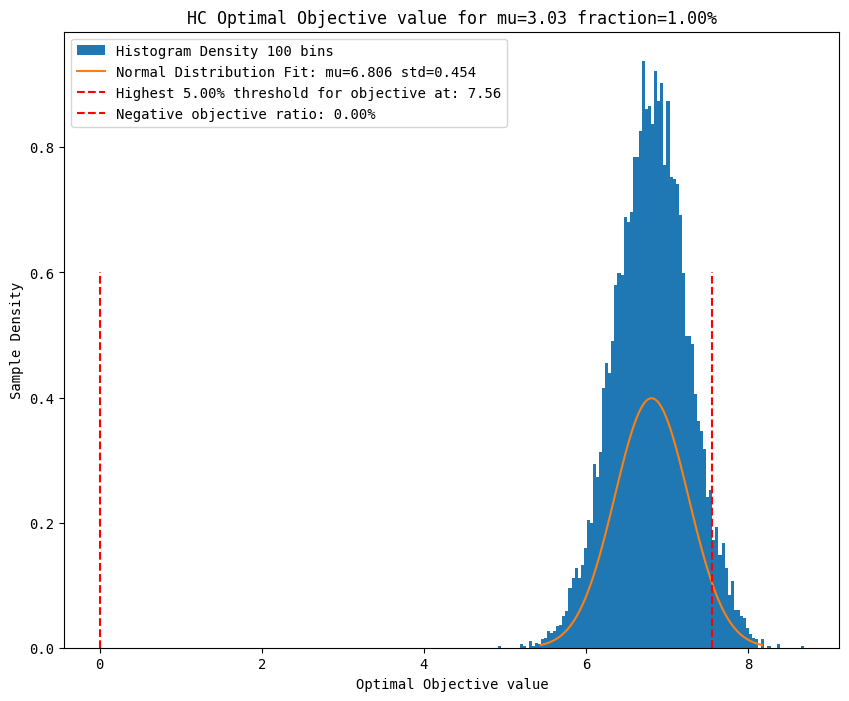

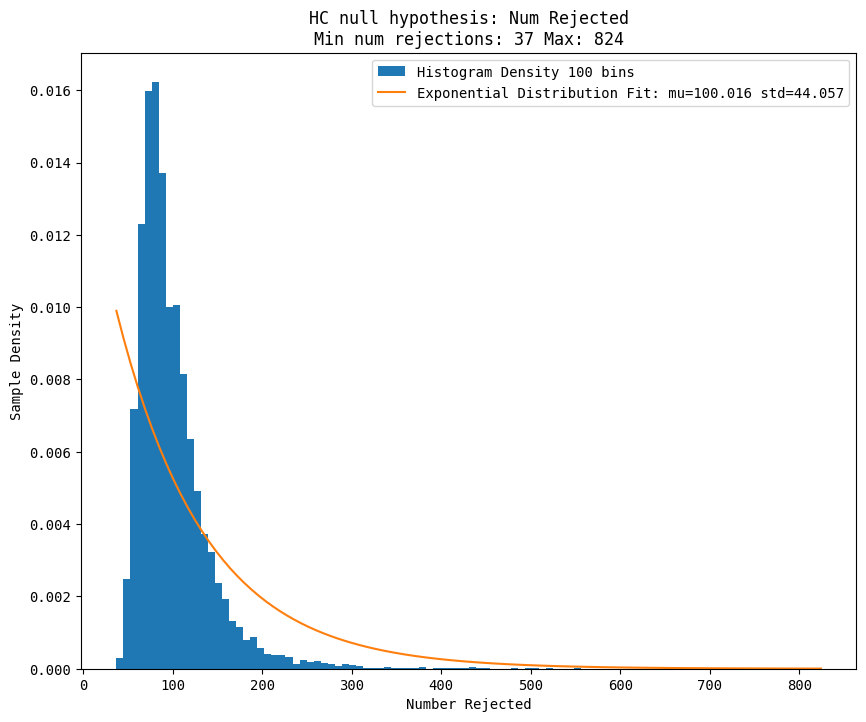

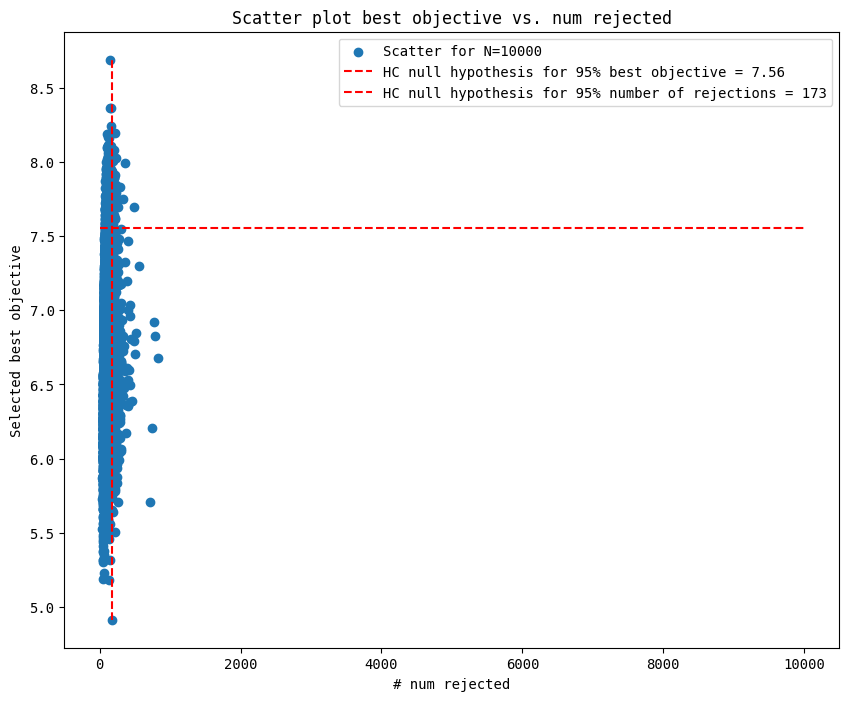

In [6]:
for mu, fraction, res_monte_carlo in collected_data:
    nums_rejected = res_monte_carlo['nums_rejected']
    best_objectives = res_monte_carlo['best_objectives']
    first_p_value = res_monte_carlo['first_p_value']
    lowest_angle = res_monte_carlo['lowest_angle']
    first_drawdown = [0,0]
    str_analysis = f' mu={mu:.2f} fraction={fraction*100:.2f}%'
    print('Analyzing'+ str_analysis)
    print('=' * 50)
    
    seed_null_objective_95 = np.argsort(best_objectives)[int(monte_carlo*(1-alpha))]
    mu = np.mean(best_objectives)
    std = np.std(best_objectives)
    bins = int(len(best_objectives)**0.5 + 0.01)
    plt.figure(figsize=(10,8))
    plt.title(label='HC Optimal Objective value for' + str_analysis)
    plt.hist(best_objectives, bins=bins, density=True, label=f'Histogram Density {bins} bins')
    x = np.linspace(-3, +3, 100)
    plt.plot(mu + x*std, scipy.stats.norm.pdf(x, 0, 1), label=f'Normal Distribution Fit: mu={mu:.3f} std={std:.3f}')
    precentile_95_obj = best_objectives[seed_null_objective_95]
    plt.vlines(ymin=0, ymax=0.6, x=precentile_95_obj, linestyles='dashed', colors='red',\
            label=f'Highest {alpha*100:.2f}% threshold for objective at: {precentile_95_obj:.2f}')
    ratio_negative_objective = sum(np.array(best_objectives) <= 0)/monte_carlo*100
    plt.vlines(ymin=0, ymax=0.6, x=0, linestyles='dashed', colors='red',\
            label=f'Negative objective ratio: {ratio_negative_objective:.2f}%')

    plt.xlabel(xlabel='Optimal Objective value')
    plt.ylabel(ylabel='Sample Density')
    plt.legend()
    plt.show()

    mu = np.mean(nums_rejected)
    std = np.std(nums_rejected)
    bins = int(len(nums_rejected)**0.5 + 0.01)
    min_rejected = np.min(nums_rejected)
    max_rejected = np.max(nums_rejected)
    seed_null_rejection_95 = np.argsort(nums_rejected)[int(monte_carlo*(1-alpha))]
    plt.figure(figsize=(10,8))
    plt.title(label=f'HC null hypothesis: Num Rejected\n' +\
            f'Min num rejections: {min_rejected} Max: {max_rejected}')
    plt.hist(nums_rejected, bins=bins, density=True, label=f'Histogram Density {bins} bins')
    x = np.linspace(min_rejected,max_rejected,100)
    plt.plot(x, scipy.stats.expon.pdf(x, loc=min_rejected-1, scale=mu),
            label=f'Exponential Distribution Fit: mu={mu:.3f} std={std:.3f}')
    plt.xlabel(xlabel='Number Rejected')
    plt.ylabel(ylabel='Sample Density')
    plt.legend()
    plt.show()

    best_objective_threshold = best_objectives[seed_null_objective_95]
    seed_null_rejection_95 = np.argsort(nums_rejected)[int(monte_carlo*(1-alpha))]
    best_rejection_threshold = nums_rejected[seed_null_rejection_95]
    plt.figure(figsize=(10,8))
    plt.title(label=f'Scatter plot best objective vs. num rejected')
    plt.scatter(x = nums_rejected, y=best_objectives, label=f'Scatter for N={N}')
    plt.hlines(xmin=0, xmax=N-1, y=best_objective_threshold,
            label=f'HC null hypothesis for 95% best objective = {best_objective_threshold:.2f}',
            linestyles='dashed', colors='red')
    plt.vlines(ymin=np.min(best_objectives), ymax=np.max(best_objectives), x=best_rejection_threshold,
            label=f'HC null hypothesis for 95% number of rejections = {best_rejection_threshold}',
            linestyles='dashed', colors='red')
    plt.xlabel(xlabel='# num rejected')
    plt.ylabel(ylabel='Selected best objective')
    plt.legend()
    plt.show()

    if max(first_drawdown) > 0:
        num_drawdowns = sum(np.array(first_drawdown) > 0)
        mu = np.mean(first_drawdown)
        std = np.std(first_drawdown)
        bins = int(len(first_drawdown)**0.5 + 0.01)
        ind_seed_sorted_drawdown = np.argsort(first_drawdown)
        plt.figure(figsize=(10,8))
        plt.title(label=f'HC objective functions First Drawdown. Drawdown rate: {num_drawdowns/monte_carlo*100:.2f}')
        plt.hist(first_drawdown, bins=bins, density=True, label=f'Histogram Density {bins} bins')
        x = np.linspace(min(first_drawdown),max(first_drawdown),100)
        plt.plot(x, scipy.stats.expon.pdf(x, loc=min(first_drawdown)-1, scale=mu),
                label=f'Exponential Distribution Fit: mu={mu:.3f} std={std:.3f}')
        plt.xlabel(xlabel='First Drawdown')
        plt.ylabel(ylabel='Sample Density')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10,8))
        plt.title(label=f'Scatter plot best objective vs. first drawdown')
        plt.scatter(x = first_drawdown, y=best_objectives, label=f'Scatter for N={N}')
        plt.hlines(xmin=0, xmax=max(first_drawdown), y=best_objective_threshold,
                label=f'HC null hypothesis for 95% best objective = {best_objective_threshold:.2f}',
                linestyles='dashed', colors='red')
        plt.xlabel(xlabel='first drawdown')
        plt.ylabel(ylabel='Selected best objective')
        plt.legend()
        plt.show()

    print()